# Project: Identify Customer Segments

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.preprocessing import Imputer

%matplotlib inline

### Step 0: Load the Data

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
feat_info_copy = feat_info.copy()

In [3]:
feat_info_copy.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [4]:
# Checking the structure of the data after it's loaded 
df = azdias.copy()
df.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Preprocessing
### Assess Missing Data
#### Convert Missing Value Codes to NaNs

In [6]:
# percent of missing values per column before converting to NaN
col_nan_perc = df.isnull().sum()/df.shape[0] * 100
col_nan_perc = col_nan_perc.sort_values(ascending=False)
col_nan_perc[:10]

KK_KUNDENTYP    65.596749
KBA05_ANTG1     14.959701
KBA05_ANTG2     14.959701
KBA05_ANTG3     14.959701
KBA05_ANTG4     14.959701
KBA05_BAUMAX    14.959701
KBA05_GBZ       14.959701
MOBI_REGIO      14.959701
REGIOTYP        13.598872
KKK             13.598872
dtype: float64

In [7]:
# number of columns having 0 missing values before processing
col_nan_perc[col_nan_perc == 0].shape

(32,)

### convert missing value codes to NaN

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
ms_1 = feat_info[feat_info['missing_or_unknown'] == '[-1]'].attribute.tolist()
ms_19 = feat_info[feat_info['missing_or_unknown'] == '[-1,9]'].attribute.tolist()
ms_10 = feat_info[feat_info['missing_or_unknown'] == '[-1,0]'].attribute.tolist()
ms_0 = feat_info[feat_info['missing_or_unknown'] == '[0]'].attribute.tolist()
ms = feat_info[feat_info['missing_or_unknown'] == '[]'].attribute.tolist()
ms_1X = feat_info[feat_info['missing_or_unknown'] == '[-1,X]'].attribute.tolist()
ms_1XX = feat_info[feat_info['missing_or_unknown'] == '[-1,XX]'].attribute.tolist()
ms_109 = feat_info[feat_info['missing_or_unknown'] == '[-1,0,9]'].attribute.tolist()
ms_XX = feat_info[feat_info['missing_or_unknown'] == '[XX]'].attribute.tolist()

In [9]:
col_names = list(df.columns)
for col in col_names:
    
    if col in ms_1:
        df = df.replace({col: {-1: np.NaN}})
    elif col in ms_19:
        df = df.replace({col: {-1: np.NaN, 9: np.NaN}})
    elif col in ms_10:
        df = df.replace({col: {-1: np.NaN, 0: np.NaN}})
    elif col in ms_0:
        df = df.replace({col: {0: np.NaN}})
    elif col in ms:
        df = df.replace({col: {None: np.NaN}})
    elif col in ms_1X:
        df = df.replace({col: {-1: np.NaN, 'X': np.NaN}})
    elif col in ms_1XX:
        df = df.replace({col: {-1: np.NaN, 'XX': np.NaN}})
    elif col in ms_109:
        df = df.replace({col: {-1: np.NaN, 0: np.NaN, 9: np.NaN}})
    else:
        df = df.replace({col : {'XX': np.NaN}})

#### Assess Missing Data in Each Column

In [10]:
# assessment of how much missing data there is in each column of the dataset
col_nan_perc = df.isnull().sum() / df.shape[0] * 100
col_nan_perc = col_nan_perc[col_nan_perc > 0]
col_nan_perc = col_nan_perc.sort_values(ascending=False)
col_nan_perc[:10]

TITEL_KZ          99.757636
AGER_TYP          76.955435
KK_KUNDENTYP      65.596749
KBA05_BAUMAX      53.468668
GEBURTSJAHR       44.020282
ALTER_HH          34.813699
REGIOTYP          17.735668
KKK               17.735668
W_KEIT_KIND_HH    16.605084
KBA05_ANTG4       14.959701
dtype: float64

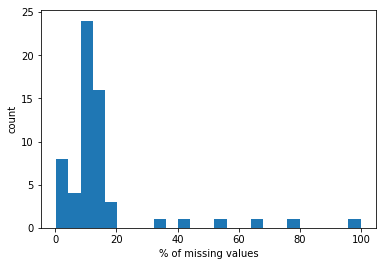

In [11]:
# Investigating patterns in the amount of missing data in each column.
col_nan_perc.plot.hist(bins =25)
plt.xlabel('% of missing values')
plt.ylabel('count')
plt.show()

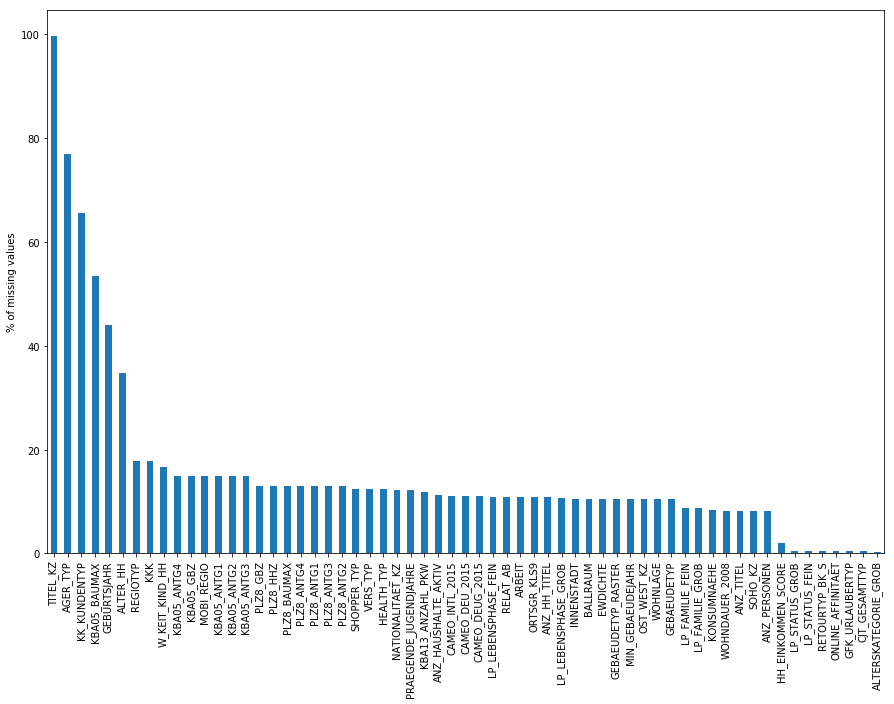

In [12]:
col_nan_perc.plot.bar(figsize=(15,10))
plt.ylabel('% of missing values')
plt.show()

In [13]:
# Removing the outlier columns from the dataset
high_nan = [col for col in df.columns if (df[col].isnull().sum()/df.shape[0]) * 100 > 20]
print(high_nan)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [14]:
df = df.drop(high_nan, axis=1)

In [15]:
df.shape

(891221, 79)

#### Discussion : Assess Missing Data in Each Column

Columns with more than 20% missing values seem to be the outlier , as seen from the histogram above.On investigation, we find that columns : 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX' have more than 20% missing values. Hence , I removed them.

#### Assess Missing Data in Each Row

In [16]:
# amount of data missing in each row of the dataset
row_nan_perc = df.isnull().sum(axis=1)
row_nan_perc = row_nan_perc[row_nan_perc > 0]
row_nan_perc = row_nan_perc.sort_values(ascending=False)

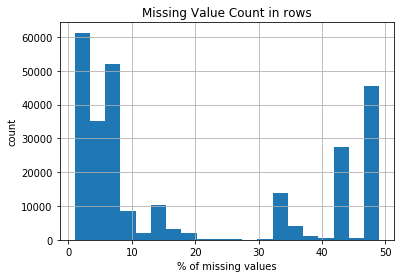

In [17]:
plt.hist(row_nan_perc, bins=20)
plt.xlabel('% of missing values')
plt.ylabel('count')
plt.grid('True')
plt.title('Missing Value Count in rows')
plt.show()

In [18]:
# code to divide the data into two subsets based on the number of missing values in each row
df_lowna = df[df.isnull().sum(axis=1)/df.shape[1] * 100  < 20].reset_index(drop=True)
df_lowna.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
1,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
2,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
3,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
4,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [19]:
df_highna = df[df.isnull().sum(axis=1)/df.shape[1] * 100 > 20]
df_highna.shape

(98934, 79)

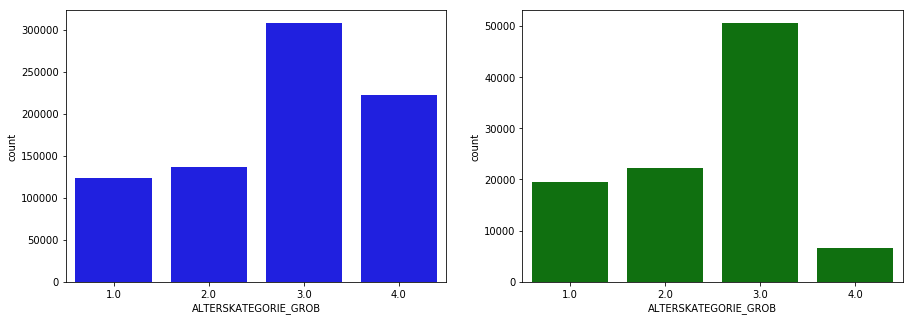

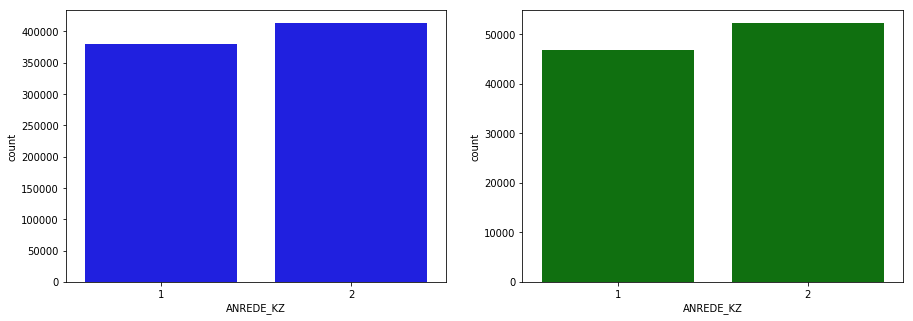

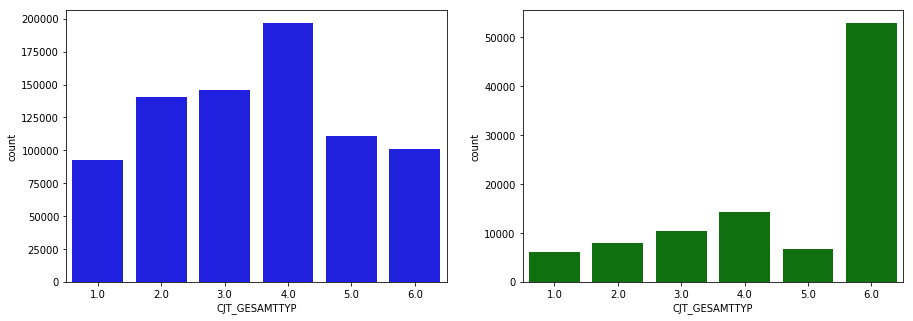

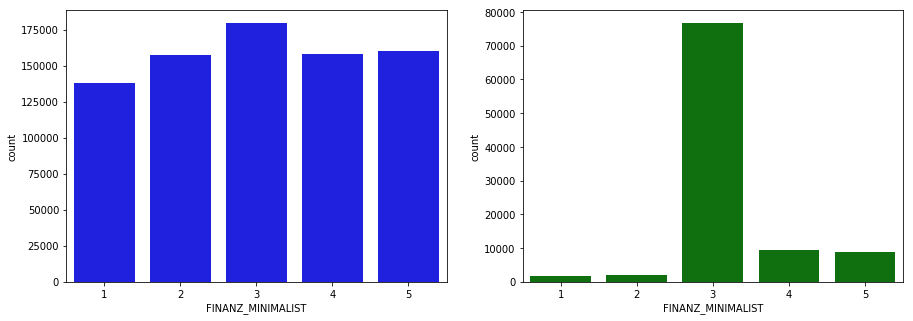

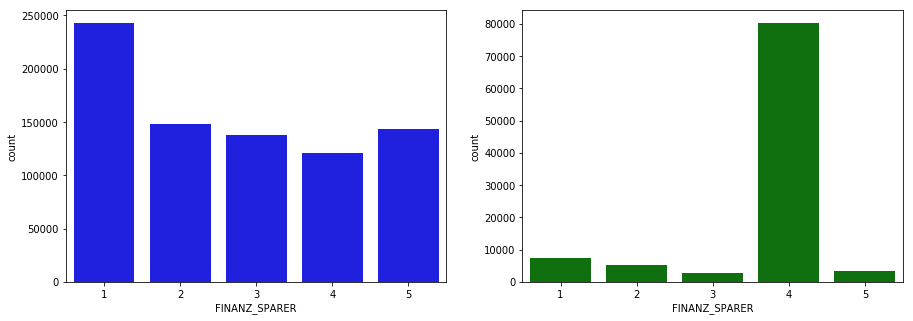

In [20]:
# Comparing the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets
common_cols = df_lowna.columns

for col in common_cols[0:5]:
    fig, axes = plt.subplots(1,2, figsize=(15, 5))
    sns.countplot(df_lowna[col],ax= axes[0], color='b')
    sns.countplot(df_highna[col],ax=axes[1], color='g')

#### Discussion : Assess Missing Data in Each Row

On observing the histogram 'Missing Value Count per rows' , we see that majority of rows have missing values between 5-8% which amounts to about 4-5 columns. I select the threshold to be 4 missing values in each row .
Further, I create two dataframes :First one with rows containing less than 4 missing values and the second dataframe consisting of rows that have more than 4 missing values.

On further investigation , I observe that the distribution of data in both the dataframe is not very different. Thus ,dropping them will not have much effect in our analysis. Thus I continue my analysis with the dataframe with few missing values.

### Select and Re-Encode Features

#### Re-Encode Categorical Features

In [21]:
# Assessing categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_cols = feat_info[feat_info.type == 'categorical'].attribute
cat_cols

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [22]:
#set attribute column as index of feat_info dataframe
feat_info.set_index('attribute', inplace=True)

In [23]:
# find categorical columns
for col in df_lowna.columns:
    if feat_info.loc[col].type == 'categorical':
        print(col, len(df_lowna[col].unique()) , df_lowna[col].dtypes)   

ANREDE_KZ 2 int64
CJT_GESAMTTYP 7 float64
FINANZTYP 6 int64
GFK_URLAUBERTYP 13 float64
GREEN_AVANTGARDE 2 int64
LP_FAMILIE_FEIN 12 float64
LP_FAMILIE_GROB 6 float64
LP_STATUS_FEIN 11 float64
LP_STATUS_GROB 6 float64
NATIONALITAET_KZ 4 float64
SHOPPER_TYP 5 float64
SOHO_KZ 2 float64
VERS_TYP 3 float64
ZABEOTYP 6 int64
GEBAEUDETYP 7 float64
OST_WEST_KZ 2 object
CAMEO_DEUG_2015 10 object
CAMEO_DEU_2015 45 object


In [24]:
# find categorical columns with more than 2 categories
non_binary=[]
for col in df_lowna.columns:
    if (feat_info.loc[col].type == 'categorical' and len(df_lowna[col].unique()) >2):
        non_binary.append(col)
non_binary

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [25]:
# drop columns with more than 2 categories
for col in non_binary:
    df_lowna.drop(col, axis=1, inplace=True)

In [26]:
# find columns with mixed types
mixed_type =[]
for col in df_lowna.columns:
    if feat_info.loc[col].type == 'mixed':
        mixed_type.append(col)        
mixed_type

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [27]:
# Re-encode categorical variable(s) to be kept in the analysis
df_lowna['OST_WEST_KZ'].unique()

array(['W', 'O'], dtype=object)

In [28]:
df_lowna['OST_WEST_KZ'] = df_lowna['OST_WEST_KZ'].replace({'W':0, 'O':1})

#### Discussion : Re-Encode Categorical Features
In this section, I drop the non-binary categorical features. I extracted mixed features as well, and will drop them later on. I engineered the column 'OST_WEST_KZ' and encoded them into 0 and 1.


#### Engineer Mixed-Type Features

In [29]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables
# Create 2 dictionaries
decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_dict = {1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1}
df_lowna['decade'] = df_lowna['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
df_lowna['movement'] = df_lowna['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)

In [30]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables
def wealth(x):
    if int(x) // 10 == 1:
        return 1
    if int(x) // 10 == 2:
        return 2
    if int(x) // 10 == 3:
        return 3
    if int(x) // 10 == 4:
        return 4
    if int(x) // 10 == 5:
        return 5
    
def life_stage(x):
    if int(x) % 10 == 1:
        return 1
    if int(x) % 10 == 2:
        return 2
    if int(x) % 10 == 3:
        return 3
    if int(x) % 10 == 4:
        return 4
    if int(x) % 10 == 5:
        return 5

In [31]:
df_lowna.CAMEO_INTL_2015.dtype

dtype('O')

In [32]:
df_lowna['CAMEO_INTL_2015'] = df_lowna.CAMEO_INTL_2015.astype('float64')
df_lowna.CAMEO_INTL_2015.dtype

dtype('float64')

In [33]:
# impute misssing values with of column CAMEO_INTL with the mean value of that column
mean_CAMEO_INTL_2015 = df_lowna['CAMEO_INTL_2015'].mean()
values = {'CAMEO_INTL_2015' : mean_CAMEO_INTL_2015}
df_lowna = df_lowna.fillna(value= values)

In [34]:
df_lowna[df_lowna.CAMEO_INTL_2015.isnull()]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement


In [35]:
df_lowna['wealth'] = df_lowna['CAMEO_INTL_2015'].apply(wealth)
df_lowna['life_stage'] = df_lowna['CAMEO_INTL_2015'].apply(life_stage)

In [36]:
# drop columns with more than 2 categories
for col in mixed_type:
    df_lowna.drop(col, axis=1, inplace=True)

In [37]:
df_lowna.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEIT', 'ORTSGR_

#### Discussion: Engineer Mixed-Type Features

In this section, the 2 mixed type columns 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' are made into 4 columns. The original columns along with other mixed type features were dropped.The mixed type categorical variables are have multiple. I end up with 64 columns.

#### Complete Feature Selection

### Created a Cleaning Function

In [67]:
def clean_data(df,feature_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # feature_info = pd.read_csv('feat_info', delimiter=';')
    ms_1 = feature_info[feature_info['missing_or_unknown'] == '[-1]'].attribute.tolist()
    ms_19 = feature_info[feature_info['missing_or_unknown'] == '[-1,9]'].attribute.tolist()
    ms_10 = feature_info[feature_info['missing_or_unknown'] == '[-1,0]'].attribute.tolist()
    ms_0 = feature_info[feature_info['missing_or_unknown'] == '[0]'].attribute.tolist()
    ms = feature_info[feature_info['missing_or_unknown'] == '[]'].attribute.tolist()
    ms_1X = feature_info[feature_info['missing_or_unknown'] == '[-1,X]'].attribute.tolist()
    ms_1XX = feature_info[feature_info['missing_or_unknown'] == '[-1,XX]'].attribute.tolist()
    ms_109 = feature_info[feature_info['missing_or_unknown'] == '[-1,0,9]'].attribute.tolist()
    ms_XX = feature_info[feature_info['missing_or_unknown'] == '[XX]'].attribute.tolist()
    
    col_names = list(df.columns)
    
    for col in col_names:
        if col in ms_1:
            df = df.replace({col: {-1: np.NaN}})
        elif col in ms_19:
            df = df.replace({col: {-1: np.NaN, 9: np.NaN}})
        elif col in ms_10:
            df = df.replace({col: {-1: np.NaN, 0: np.NaN}})
        elif col in ms_0:
            df = df.replace({col: {0: np.NaN}})
        elif col in ms:
            df = df.replace({col: {None: np.NaN}})
        elif col in ms_1X:
            df = df.replace({col: {-1: np.NaN, 'X': np.NaN}})
        elif col in ms_1XX:
            df = df.replace({col: {-1: np.NaN, 'XX': np.NaN}})
        elif col in ms_109:
            df = df.replace({col: {-1: np.NaN, 0: np.NaN, 9: np.NaN}})
        else:
            df = df.replace({col : {'XX': np.NaN}})
    
    # remove selected columns
    missing_columns = ['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX']
    for col in missing_columns:
        df.drop(col, axis=1, inplace=True)
        
    # remove selected rows
    df_lowna = df[df.isnull().sum(axis=1)/df.shape[1] * 100 < 20].reset_index(drop=True)
    
    
    # select, re-encode, and engineer column values.
    non_binary=['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN',
                'LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP','VERS_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015']
    for col in non_binary:
        df_lowna.drop(col, axis=1, inplace=True)

        
    # engineer mixed features
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_dict = {1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1}
    df_lowna['decade'] = df_lowna['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
    df_lowna['movement'] = df_lowna['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    
    
    
    # impute missing values in column CAMEO_INTL_2015 with its mean
    
    df_lowna['CAMEO_INTL_2015'] = df_lowna.CAMEO_INTL_2015.astype('float64')
    mean_CAMEO_INTL_2015 = df_lowna['CAMEO_INTL_2015'].mean()
    values = {'CAMEO_INTL_2015' : mean_CAMEO_INTL_2015}
    df_lowna = df_lowna.fillna(value= values)
    
    df_lowna['wealth'] = df_lowna['CAMEO_INTL_2015'].apply(wealth)
    df_lowna['life_stage'] = df_lowna['CAMEO_INTL_2015'].apply(life_stage)
    
    mixed_type =['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX','CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE']
    for col in mixed_type:
        df_lowna.drop(col, axis=1, inplace=True)
    
    
    df_lowna['OST_WEST_KZ'] = df_lowna['OST_WEST_KZ'].replace({'W':0, 'O':1})
    
    # Return the cleaned dataframe.
    return df_lowna

## Feature Transformation

### Apply Feature Scaling

In [39]:
# prior investigation
# columns containing null values
null_columns = df_lowna.columns[df_lowna.isnull().any()]
df_lowna[null_columns].isnull().sum()

ALTERSKATEGORIE_GROB     2740
HEALTH_TYP              35855
RETOURTYP_BK_S           4368
W_KEIT_KIND_HH          58049
ANZ_HAUSHALTE_AKTIV      6180
ANZ_HH_TITEL             3598
KONSUMNAEHE                56
KBA05_ANTG1             34663
KBA05_ANTG2             34663
KBA05_ANTG3             34663
KBA05_ANTG4             34663
KBA05_GBZ               34663
BALLRAUM                  569
EWDICHTE                  569
INNENSTADT                569
GEBAEUDETYP_RASTER          5
KKK                     60366
MOBI_REGIO              34663
ONLINE_AFFINITAET        4368
REGIOTYP                60366
KBA13_ANZAHL_PKW         8377
PLZ8_ANTG1              17953
PLZ8_ANTG2              17953
PLZ8_ANTG3              17953
PLZ8_ANTG4              17953
PLZ8_HHZ                17953
PLZ8_GBZ                17953
ARBEIT                   4165
ORTSGR_KLS9              4071
RELAT_AB                 4165
decade                  27615
movement                27615
dtype: int64

In [40]:
# percentage of NaN per row
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
imputed_df = pd.DataFrame(imputer.fit_transform(df_lowna))
imputed_df.columns = df_lowna.columns

In [41]:
df_lowna = imputed_df
df_lowna.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,0.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,1.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,0.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,0.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,0.0,5.0,4.0


In [42]:
df_lowna.columns[df_lowna.isnull().any()]

Index([], dtype='object')

In [43]:
# Apply feature scaling to the general population demographics data.
# fit scaler without NaN
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df_lowna))
scaled_df.columns = df_lowna.columns
df_lowna = scaled_df

In [44]:
df_lowna.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
0,-1.766262,0.958103,-1.492816,1.538634,-1.042098,1.466664,0.966060,1.335003,-0.531050,1.083295,...,0.418307,1.440698,0.563306,-0.169827,-0.129548,0.682837,1.166699,-0.553051,1.188359,-1.264683
1,0.200742,0.958103,-1.492816,0.865411,-1.768435,-0.570410,0.250485,1.335003,1.883063,1.083295,...,-0.972746,0.402065,0.563306,-0.169827,-0.129548,-0.791434,1.166699,1.873450,-0.865119,0.749068
2,1.184244,0.958103,0.684789,-0.481036,1.136914,-0.570410,-1.180665,-0.799862,-0.531050,-0.272064,...,-0.972746,-0.636568,0.563306,-1.174089,-1.000290,-0.054298,-0.229956,-0.553051,-1.549612,-0.593433
3,0.200742,-1.043729,0.684789,0.192187,0.410577,-1.249434,0.250485,-0.799862,-0.531050,1.083295,...,0.418307,-0.636568,-0.346657,0.834436,0.305823,1.419973,-0.229956,-0.553051,0.503866,0.077817
4,-1.766262,0.958103,-0.041079,-1.154259,1.136914,-0.570410,-0.465090,1.335003,-0.531050,1.083295,...,0.418307,1.440698,1.473269,-1.174089,-1.000290,-0.054298,-1.626612,-0.553051,1.188359,0.749068


### Perform Dimensionality Reduction

In [45]:
# Apply PCA to the data.
pca = PCA()
df_lowna_pca = pca.fit_transform(df_lowna)

In [46]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.grid('True')
    plt.title('Explained Variance Per Principal Component')

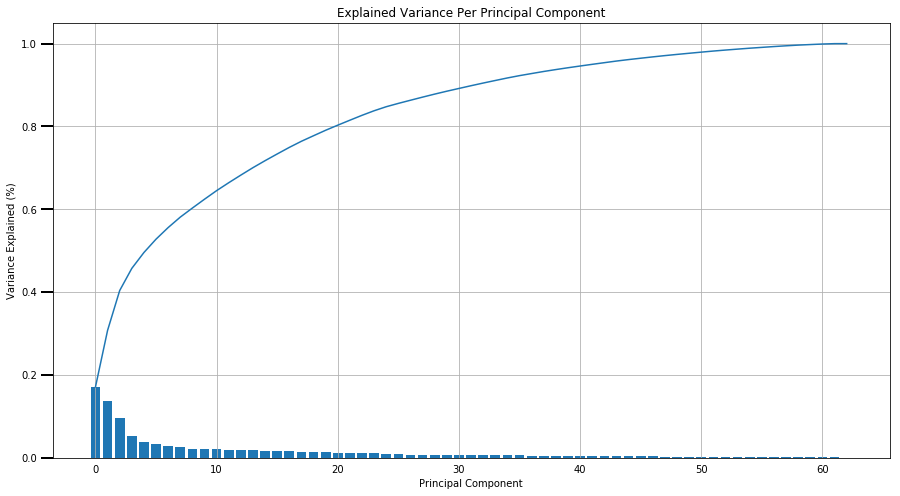

In [47]:
scree_plot(pca)

In [48]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=44)
df_lowna_pca = pca.fit_transform(df_lowna)

In [49]:
df_lowna_pca.shape

(792287, 44)

### Discussion : Perform Dimensionality Reduction

By looking at the scree plot, we can see that , at approximately 44 features , 100% variance is explained. So I select the number of components to be 44.

### Interpret Principal Components

In [50]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def pca_sort_results(data, pca, component_num):
    components = pd.DataFrame(pca.components_, columns = data.columns)
    return components.iloc[[component_num]].sort_values(by=component_num, ascending=False, axis=1)

In [51]:
# top positive
pca_sort_results(df_lowna, pca, 1).T.head()

,1
ALTERSKATEGORIE_GROB,0.261183
FINANZ_VORSORGER,0.233708
SEMIO_ERL,0.231193
SEMIO_LUST,0.183961
RETOURTYP_BK_S,0.163854


In [52]:
pca_sort_results(df_lowna, pca, 1).T.tail(10)

,1
SEMIO_RAT,-0.171098
SEMIO_FAM,-0.184241
FINANZ_ANLEGER,-0.205131
SEMIO_KULT,-0.219830
FINANZ_UNAUFFAELLIGER,-0.228061
SEMIO_PFLICHT,-0.228743
SEMIO_TRADV,-0.231815
FINANZ_SPARER,-0.236903
decade,-0.252235
SEMIO_REL,-0.255367


In [53]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_sort_results(df_lowna, pca, 2).T.head(10)

,2
SEMIO_VERT,0.345595
SEMIO_SOZ,0.262666
SEMIO_FAM,0.250121
SEMIO_KULT,0.235120
FINANZ_MINIMALIST,0.155868
RETOURTYP_BK_S,0.108662
FINANZ_VORSORGER,0.100919
W_KEIT_KIND_HH,0.090862
ALTERSKATEGORIE_GROB,0.079031
SEMIO_REL,0.070125


In [54]:
pca_sort_results(df_lowna, pca, 2).T.tail(10)

,2
FINANZ_UNAUFFAELLIGER,-0.099595
FINANZ_SPARER,-0.106113
decade,-0.107778
SEMIO_ERL,-0.175852
FINANZ_ANLEGER,-0.188966
SEMIO_RAT,-0.217284
SEMIO_KRIT,-0.275530
SEMIO_DOM,-0.314230
SEMIO_KAEM,-0.337081
ANREDE_KZ,-0.368597


In [55]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_sort_results(df_lowna, pca, 3).T.head(10)

,3
GREEN_AVANTGARDE,0.399897
movement,0.399214
EWDICHTE,0.262848
ORTSGR_KLS9,0.250178
PLZ8_HHZ,0.140403
ONLINE_AFFINITAET,0.135304
SEMIO_DOM,0.111617
PLZ8_ANTG2,0.106935
PLZ8_ANTG3,0.102609
ANZ_PERSONEN,0.099131


In [56]:
pca_sort_results(df_lowna, pca, 3).T.tail(10)

,3
FINANZ_HAUSBAUER,-0.106683
OST_WEST_KZ,-0.107804
wealth,-0.123106
FINANZ_ANLEGER,-0.125388
KONSUMNAEHE,-0.151448
REGIOTYP,-0.210215
INNENSTADT,-0.222622
BALLRAUM,-0.237031
HH_EINKOMMEN_SCORE,-0.249905
KKK,-0.273288


### Discussion :Interpret Principal Components

1. The first component component seems to capture the age, shopping behaviour and financial affluence       of    the person.This can be said because the following features :ALTERSKATEGORIE_GROB, SEMIO_ERL, FINANZ_VORSORGER,           SEMIO_LUST,RETOURTYP_BK_S have high positive weights.The assumption is supported by the negative weights of   SEMIO_RAT,SEMIO_FAM,FINANZ_ANLEGER,SEMIO_KULT,FINANZ_UNAUFFAELLIGER

2. The second component seems to capture personality types. This can be said because the following features : SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM, SEMIO_KULT, FINANZ_MINIMALIST have positive weights and belong to the same category as observed from the data dictionary.So, they will have similar trends on increasing or decreasing them.

## Clustering

### Apply Clustering to General Population

In [57]:
# Over a number of different cluster counts,
# run k-means clustering on the data and
# compute the average within-cluster distances.  
def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters = center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [58]:
scores = []
centres = list(np.arange(2, 30, 2))
for centre in centres:
    scores.append(get_kmeans_score(df_lowna, centre))

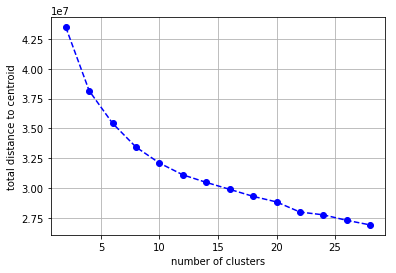

In [59]:
# Investigate the change in within-cluster distance across number of clusters.

plt.plot(centres, scores, linestyle='--', marker='o', color='b')
plt.xlabel('number of clusters')
plt.ylabel('total distance to centroid')
plt.grid('True')

In [58]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=10,random_state=0)
model_general = kmeans.fit(df_lowna_pca)

In [59]:
predict_general = model_general.predict(df_lowna_pca)

In [60]:
(predict_general == 0).sum()

86191

In [61]:
model_general.cluster_centers_.shape

(10, 44)

### Discussion: Apply Clustering to General Population

On observing the above graph, I find that the elbow is not very clear. But, the slope seems to decrease after around 10 clusters. Thus I chose the number of clusters to be 10.

### Apply All Steps to the Customer Data

In [62]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [63]:
customers.shape

(191652, 85)

In [68]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
feature_info = feat_info_copy.copy()
df_cust = clean_data(customers, feature_info)

In [69]:
df_cust.shape

(140898, 63)

In [70]:
# Impute
df_cust_imp = imputer.transform(df_cust)

In [71]:
# scale
df_cust_sc = scaler.transform(df_cust_imp)

In [72]:
df_cust_pca = pca.transform(df_cust_sc)
df_cust_pca.shape

(140898, 44)

In [73]:
predict_customers = model_general.predict(df_cust_pca)

In [74]:
(predict_customers == 1).sum()

1528

### Compare Customer Data to Demographics Data

In [75]:
(predict_general == 8).sum()

68026

In [76]:
# Comparing the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population
general_proportion = []
customers_proportion = []

x = [i for i in range(10)]

for i in range(10):
    general_proportion.append((predict_general == i).sum()/len(predict_general))
    customers_proportion.append((predict_customers == i).sum()/len(predict_customers))
    
# dataframe showing the proportion of both customer and general data in each cluster
df_proportion = pd.DataFrame({'cluster' : x, 'prop_general' : general_proportion, 'prop_customers':customers_proportion})
df_proportion.head()

,cluster,prop_customers,prop_general
0,0,0.015955,0.108788
1,1,0.010845,0.107388
2,2,0.095793,0.124618
3,3,0.109114,0.120559
4,4,0.195666,0.114378


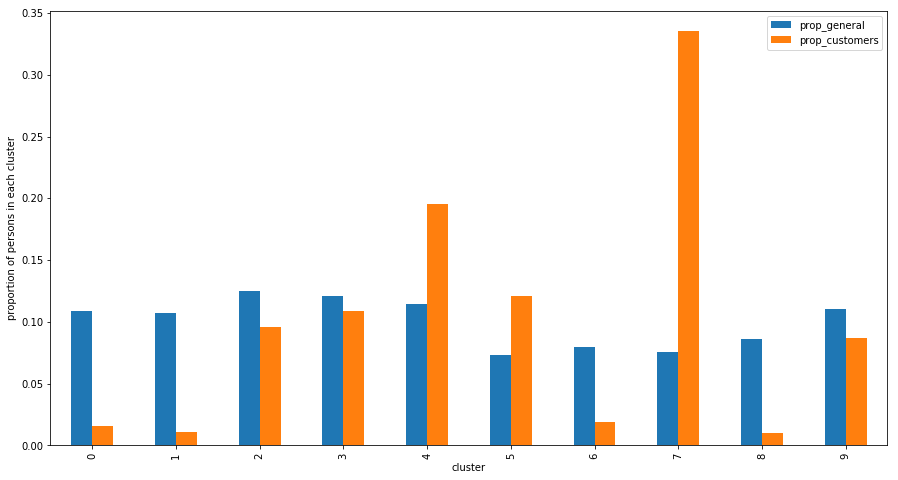

In [77]:
df_proportion.plot(x='cluster', y = ['prop_general', 'prop_customers'], kind='bar', figsize=(15,8))
plt.ylabel('proportion of persons in each cluster')
plt.show()

In [78]:
# kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population
from IPython.display import display

df = pd.DataFrame((scaler.inverse_transform(pca.inverse_transform(df_cust_pca[np.where(predict_customers == 8)]))).round())
df.columns = df_lowna.columns
pd.options.display.max_columns = None
display(df.head(10))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
0,2.0,1.0,2.0,4.0,2.0,3.0,4.0,3.0,-0.0,1.0,3.0,7.0,7.0,7.0,3.0,6.0,6.0,3.0,7.0,4.0,2.0,2.0,3.0,7.0,6.0,-0.0,1.0,0.0,5.0,5.0,9.0,17.0,-0.0,1.0,1992.0,-0.0,-0.0,-0.0,2.0,1.0,1.0,1.0,6.0,3.0,2.0,3.0,1.0,5.0,6.0,145.0,1.0,3.0,3.0,2.0,3.0,1.0,3.0,8.0,5.0,6.0,0.0,4.0,1.0
1,2.0,1.0,3.0,3.0,3.0,1.0,2.0,2.0,1.0,2.0,3.0,7.0,7.0,6.0,7.0,6.0,1.0,3.0,7.0,5.0,1.0,4.0,3.0,5.0,5.0,-0.0,2.0,0.0,5.0,4.0,9.0,11.0,-0.0,2.0,1992.0,-0.0,0.0,0.0,3.0,0.0,2.0,2.0,6.0,3.0,3.0,1.0,2.0,4.0,3.0,435.0,2.0,4.0,2.0,0.0,3.0,3.0,4.0,8.0,4.0,5.0,1.0,4.0,5.0
2,2.0,1.0,2.0,5.0,2.0,4.0,3.0,4.0,-0.0,3.0,3.0,7.0,7.0,7.0,5.0,6.0,2.0,2.0,8.0,4.0,2.0,1.0,2.0,6.0,5.0,0.0,1.0,-0.0,6.0,1.0,9.0,18.0,0.0,1.0,1992.0,1.0,-0.0,-0.0,-0.0,2.0,1.0,1.0,6.0,2.0,2.0,2.0,1.0,4.0,3.0,547.0,1.0,1.0,2.0,2.0,4.0,2.0,4.0,9.0,3.0,6.0,-0.0,4.0,1.0
3,2.0,1.0,3.0,3.0,3.0,2.0,1.0,3.0,0.0,3.0,5.0,7.0,7.0,6.0,7.0,7.0,3.0,3.0,8.0,5.0,2.0,4.0,2.0,6.0,5.0,-0.0,4.0,0.0,6.0,2.0,9.0,48.0,1.0,3.0,1994.0,1.0,-1.0,-0.0,-0.0,2.0,2.0,6.0,5.0,4.0,2.0,3.0,1.0,5.0,2.0,147.0,2.0,0.0,2.0,2.0,3.0,1.0,3.0,7.0,2.0,5.0,0.0,5.0,4.0
4,2.0,1.0,4.0,2.0,2.0,1.0,3.0,3.0,-0.0,1.0,5.0,7.0,7.0,7.0,5.0,7.0,2.0,2.0,8.0,4.0,2.0,2.0,3.0,7.0,5.0,0.0,1.0,-0.0,4.0,4.0,4.0,5.0,0.0,2.0,1992.0,1.0,2.0,0.0,1.0,0.0,3.0,2.0,6.0,4.0,4.0,3.0,3.0,4.0,5.0,506.0,2.0,3.0,2.0,1.0,4.0,3.0,4.0,8.0,3.0,4.0,-0.0,4.0,5.0
5,1.0,1.0,2.0,5.0,2.0,4.0,5.0,3.0,1.0,2.0,4.0,7.0,7.0,7.0,5.0,6.0,2.0,2.0,7.0,4.0,1.0,2.0,2.0,6.0,5.0,0.0,1.0,-0.0,5.0,6.0,4.0,0.0,0.0,1.0,1992.0,-0.0,1.0,2.0,0.0,0.0,4.0,7.0,5.0,8.0,2.0,2.0,3.0,3.0,4.0,265.0,1.0,4.0,3.0,1.0,3.0,3.0,3.0,6.0,5.0,6.0,1.0,5.0,4.0
6,2.0,1.0,2.0,4.0,2.0,2.0,3.0,3.0,1.0,1.0,4.0,7.0,7.0,6.0,4.0,7.0,2.0,1.0,7.0,3.0,1.0,1.0,1.0,6.0,5.0,0.0,5.0,-0.0,6.0,2.0,3.0,8.0,0.0,1.0,1993.0,0.0,-0.0,2.0,3.0,-0.0,2.0,6.0,6.0,1.0,3.0,1.0,1.0,3.0,1.0,672.0,1.0,4.0,3.0,2.0,5.0,3.0,3.0,7.0,5.0,6.0,1.0,3.0,4.0
7,3.0,1.0,2.0,4.0,2.0,3.0,5.0,2.0,-0.0,3.0,4.0,3.0,5.0,3.0,2.0,7.0,4.0,4.0,6.0,2.0,5.0,5.0,3.0,1.0,4.0,0.0,1.0,-0.0,5.0,4.0,4.0,6.0,0.0,1.0,1992.0,-0.0,0.0,-0.0,3.0,-0.0,2.0,6.0,6.0,3.0,3.0,4.0,2.0,4.0,5.0,809.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,7.0,4.0,6.0,-0.0,4.0,3.0
8,2.0,1.0,4.0,3.0,4.0,1.0,3.0,3.0,0.0,3.0,5.0,7.0,7.0,7.0,7.0,6.0,6.0,2.0,7.0,5.0,5.0,4.0,2.0,6.0,5.0,0.0,1.0,0.0,5.0,4.0,3.0,3.0,-0.0,4.0,1992.0,-0.0,2.0,2.0,0.0,0.0,4.0,1.0,6.0,4.0,4.0,3.0,3.0,2.0,5.0,333.0,2.0,4.0,2.0,1.0,3.0,3.0,5.0,8.0,5.0,4.0,0.0,4.0,1.0
9,3.0,1.0,3.0,3.0,2.0,1.0,5.0,3.0,0.0,3.0,4.0,6.0,6.0,4.0,6.0,7.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,-0.0,0.0,0.0,4.0,4.0,9.0,9.0,-0.0,2.0,1992.0,-0.0,-0.0,-0.0,2.0,1.0,1.0,6.0,6.0,2.0,3.0,1.0,1.0,3.0,2.0,729.0,1.0,4.0,3.0,1.0,5.0,3.0,3.0,7.0,5.0,5.0,0.0,4.0,4.0


In [79]:
# kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population
df = pd.DataFrame((scaler.inverse_transform(pca.inverse_transform(df_cust_pca[np.where(predict_customers == 6)]))).round())
df.columns = df_lowna.columns
display(df.head(10))


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
0,2.0,1.0,4.0,3.0,2.0,1.0,5.0,1.0,1.0,2.0,3.0,7.0,7.0,6.0,7.0,8.0,2.0,3.0,6.0,5.0,1.0,2.0,2.0,5.0,4.0,0.0,2.0,-0.0,3.0,1.0,7.0,1.0,-0.0,2.0,2011.0,0.0,2.0,1.0,1.0,0.0,3.0,3.0,5.0,2.0,4.0,1.0,3.0,5.0,1.0,634.0,2.0,3.0,2.0,1.0,4.0,4.0,3.0,7.0,4.0,6.0,1.0,1.0,2.0
1,2.0,1.0,4.0,4.0,1.0,4.0,5.0,1.0,-0.0,3.0,3.0,7.0,7.0,5.0,7.0,7.0,3.0,3.0,6.0,2.0,5.0,4.0,3.0,8.0,5.0,-0.0,2.0,-0.0,2.0,1.0,9.0,1.0,0.0,3.0,1992.0,0.0,2.0,1.0,0.0,0.0,4.0,7.0,2.0,6.0,4.0,3.0,4.0,5.0,5.0,622.0,3.0,2.0,1.0,0.0,3.0,4.0,1.0,2.0,1.0,6.0,-0.0,1.0,5.0
2,2.0,1.0,5.0,3.0,2.0,3.0,5.0,1.0,1.0,3.0,1.0,7.0,7.0,7.0,3.0,7.0,2.0,3.0,7.0,4.0,5.0,4.0,2.0,7.0,5.0,-0.0,1.0,-0.0,1.0,4.0,3.0,1.0,-0.0,4.0,1992.0,-0.0,4.0,1.0,-0.0,-0.0,5.0,7.0,2.0,8.0,4.0,2.0,5.0,3.0,2.0,1390.0,2.0,3.0,2.0,1.0,6.0,5.0,2.0,3.0,3.0,5.0,1.0,1.0,5.0
3,3.0,1.0,2.0,5.0,2.0,5.0,4.0,2.0,1.0,1.0,1.0,6.0,6.0,5.0,6.0,5.0,6.0,4.0,5.0,5.0,3.0,5.0,2.0,3.0,4.0,-0.0,3.0,0.0,4.0,2.0,9.0,2.0,-0.0,3.0,1992.0,-0.0,1.0,2.0,0.0,0.0,4.0,5.0,2.0,6.0,3.0,1.0,3.0,4.0,1.0,538.0,2.0,3.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,6.0,1.0,4.0,3.0
4,2.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,0.0,1.0,3.0,7.0,7.0,7.0,5.0,6.0,3.0,1.0,7.0,5.0,1.0,1.0,1.0,5.0,5.0,-0.0,1.0,0.0,2.0,6.0,9.0,2.0,-0.0,4.0,1992.0,-0.0,4.0,-0.0,-0.0,-0.0,4.0,7.0,2.0,8.0,4.0,1.0,5.0,4.0,3.0,1320.0,3.0,3.0,1.0,0.0,5.0,6.0,2.0,2.0,2.0,3.0,0.0,1.0,3.0
5,2.0,1.0,3.0,4.0,2.0,3.0,4.0,2.0,1.0,1.0,4.0,7.0,7.0,6.0,4.0,8.0,3.0,1.0,7.0,3.0,1.0,1.0,1.0,7.0,5.0,0.0,5.0,-0.0,4.0,2.0,9.0,1.0,0.0,5.0,1992.0,-0.0,2.0,3.0,-0.0,-0.0,3.0,6.0,2.0,4.0,4.0,2.0,4.0,5.0,3.0,744.0,3.0,3.0,1.0,-0.0,3.0,4.0,1.0,2.0,1.0,6.0,1.0,2.0,2.0
6,2.0,1.0,4.0,4.0,2.0,4.0,4.0,1.0,1.0,1.0,1.0,7.0,7.0,6.0,4.0,7.0,2.0,1.0,7.0,2.0,2.0,2.0,1.0,8.0,5.0,0.0,2.0,-0.0,4.0,4.0,9.0,1.0,0.0,4.0,1992.0,-0.0,3.0,1.0,0.0,-0.0,4.0,6.0,2.0,6.0,4.0,3.0,4.0,5.0,6.0,320.0,3.0,2.0,0.0,0.0,2.0,3.0,1.0,3.0,1.0,6.0,1.0,1.0,3.0
7,3.0,1.0,4.0,4.0,2.0,4.0,5.0,1.0,0.0,3.0,1.0,6.0,4.0,4.0,1.0,6.0,1.0,4.0,5.0,2.0,5.0,5.0,3.0,4.0,2.0,-0.0,2.0,0.0,2.0,3.0,8.0,2.0,-0.0,3.0,1992.0,0.0,4.0,1.0,0.0,-0.0,4.0,3.0,4.0,5.0,4.0,3.0,4.0,5.0,4.0,400.0,4.0,3.0,1.0,-0.0,3.0,3.0,3.0,6.0,2.0,6.0,0.0,2.0,4.0
8,2.0,1.0,4.0,1.0,5.0,1.0,2.0,4.0,-0.0,1.0,3.0,7.0,7.0,7.0,5.0,6.0,2.0,2.0,7.0,5.0,1.0,1.0,1.0,5.0,5.0,0.0,3.0,-0.0,4.0,4.0,9.0,3.0,0.0,2.0,1992.0,-0.0,2.0,2.0,-0.0,-0.0,5.0,7.0,3.0,8.0,4.0,1.0,4.0,3.0,2.0,556.0,2.0,3.0,2.0,1.0,3.0,3.0,2.0,3.0,3.0,3.0,-0.0,4.0,3.0
9,1.0,1.0,3.0,4.0,2.0,5.0,5.0,3.0,-0.0,2.0,4.0,7.0,6.0,7.0,5.0,7.0,3.0,1.0,7.0,5.0,1.0,2.0,1.0,5.0,6.0,-0.0,2.0,0.0,1.0,6.0,9.0,3.0,-0.0,5.0,2000.0,1.0,3.0,0.0,-0.0,-0.0,5.0,6.0,1.0,5.0,4.0,3.0,5.0,2.0,5.0,1487.0,3.0,2.0,1.0,-0.0,5.0,6.0,2.0,1.0,1.0,5.0,0.0,1.0,2.0


### Discussion 3.3: Compare Customer Data to Demographics Data

1. Cluster 8 is overrepresented and Cluster 6 seems underrepresented.
2. Cluster 8 seems to represent customers with a good financial background, owning a house for longer period ,cultural minded and older in age.
3. Cluster 6 seems to represent younger people, with a medium financial background.
